In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import time
import json

In [3]:
def verbalise_dataset(train, test):
    print('Train shape:' + str(train.shape))
    print('Test shape:' + str(test.shape))
    print()

In [4]:
def load_file(filepath):

    start_time = time.time()
    df = pd.read_csv(filepath, low_memory=False)
    elapsed_time = time.time() - start_time
    print("Dataset loaded, time elapsed: " + str(elapsed_time))

    return df

train = load_file('../data/train.csv')  # (76020, 371)
test = load_file('../data/test.csv')  # (75818, 370)
verbalise_dataset(train, test)

Dataset loaded, time elapsed: 15.51412296295166
Dataset loaded, time elapsed: 17.749540090560913
Train shape:(76020, 371)
Test shape:(75818, 370)



In [5]:
def remove_duplicate_col(train, test):

    print('Removing duplicated features')
    output = []
    columns = train.columns  # list of headers
    for i in range(len(columns)-1):
        for j in range(i+1,len(columns)):
            if np.array_equal(train[columns[i]].values, train[columns[j]].values) and columns[j] not in output:
                    output.append(columns[j])
    
    train = train.drop(output, axis=1)
    test = test.drop(output, axis=1)

    return train, test


clean_train, clean_test = remove_duplicate_col(train, test)
verbalise_dataset(clean_train, clean_test)

Removing duplicated features
Train shape:(76020, 309)
Test shape:(75818, 308)



In [6]:
def remove_constant_col(train, test):

    print('Removing constant features')
    columns = []
    for col in train.columns:
        if train[col].std() == 0:
            columns.append(col)

    train = train.drop(columns, axis=1)
    test = test.drop(columns, axis=1)

    return train, test

clean_train, clean_test = remove_constant_col(clean_train, clean_test)
verbalise_dataset(clean_train, clean_test)

Removing constant features
Train shape:(76020, 308)
Test shape:(75818, 307)



In [7]:
# split data into train and test
X = clean_train.drop(["TARGET","ID"],axis=1)
Y = clean_train['TARGET'].values

test_id = clean_test.ID
test = clean_test.drop(["ID"],axis=1)

In [40]:
average_score = 0.0
train_pred = np.zeros(test.shape[0])
target = np.zeros(test.shape[0])
seeds = [2534324, 13454236, 34623, 1367457, 12321]

for i in range(len(seeds)):
    
    n_splits = 10
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seeds[i])

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Feature selection
        clf = lgb.LGBMClassifier()
        selector = clf.fit(X_train, Y_train)
        fs = SelectFromModel(selector, prefit=True)
        X_train_transformed = fs.transform(X_train)
        X_test_transformed = fs.transform(X_test)
        clean_test = fs.transform(test)

        feature_idx = fs.get_support()
        features = X_train.columns[feature_idx]

        d_train = lgb.Dataset(X_train_transformed, label=Y_train)
        params = json.load(open('params' + str(i) + '.json'))
        params['boosting_type'] = 'gbdt'
        params['objective'] = 'binary'
        params['metric'] = 'auc'

        params['num_leaves'] = round(params['num_leaves'])
        params['max_depth'] = round(params['max_depth'])

        clf = lgb.train(train_set=d_train, params=params)

        Y_pred=clf.predict(X_test_transformed)
        score = roc_auc_score(Y_test, Y_pred)
        average_score += score / n_splits / len(seeds)
        print("Score: " + str(score))

        probs = clf.predict(clean_test)
        target += probs / n_splits / len(seeds)
    
print("Average training score: " + str(average_score))

Score: 0.8347774377565514
Score: 0.8311430627935186
Score: 0.8498949536335304
Score: 0.8426802681651492
Score: 0.8263592890611171
Score: 0.8315615528023512
Score: 0.8477259975764481
Score: 0.8314828305957269
Score: 0.8351365109802309
Score: 0.8360945989133909
Score: 0.8480134692083632
Score: 0.8562936382058891
Score: 0.8258018630315512
Score: 0.8413761187767934
Score: 0.833092995498273
Score: 0.8289082049016177
Score: 0.833444515178142
Score: 0.8288458641946377
Score: 0.8271287038305255
Score: 0.8394514450075332
Score: 0.8424458870322699
Score: 0.83496443426504
Score: 0.8353930035525103
Score: 0.8334643094902123
Score: 0.8500799280670148
Score: 0.8302417044768363
Score: 0.8208539675764617
Score: 0.8265874924519965
Score: 0.8335228050951924
Score: 0.847955759485002
Score: 0.8511667035199932
Score: 0.8164902256788519
Score: 0.8262307397930744
Score: 0.8200733436142411
Score: 0.849030146964804
Score: 0.8484558843939368
Score: 0.8304810563883072
Score: 0.8466220665170794
Score: 0.849219969

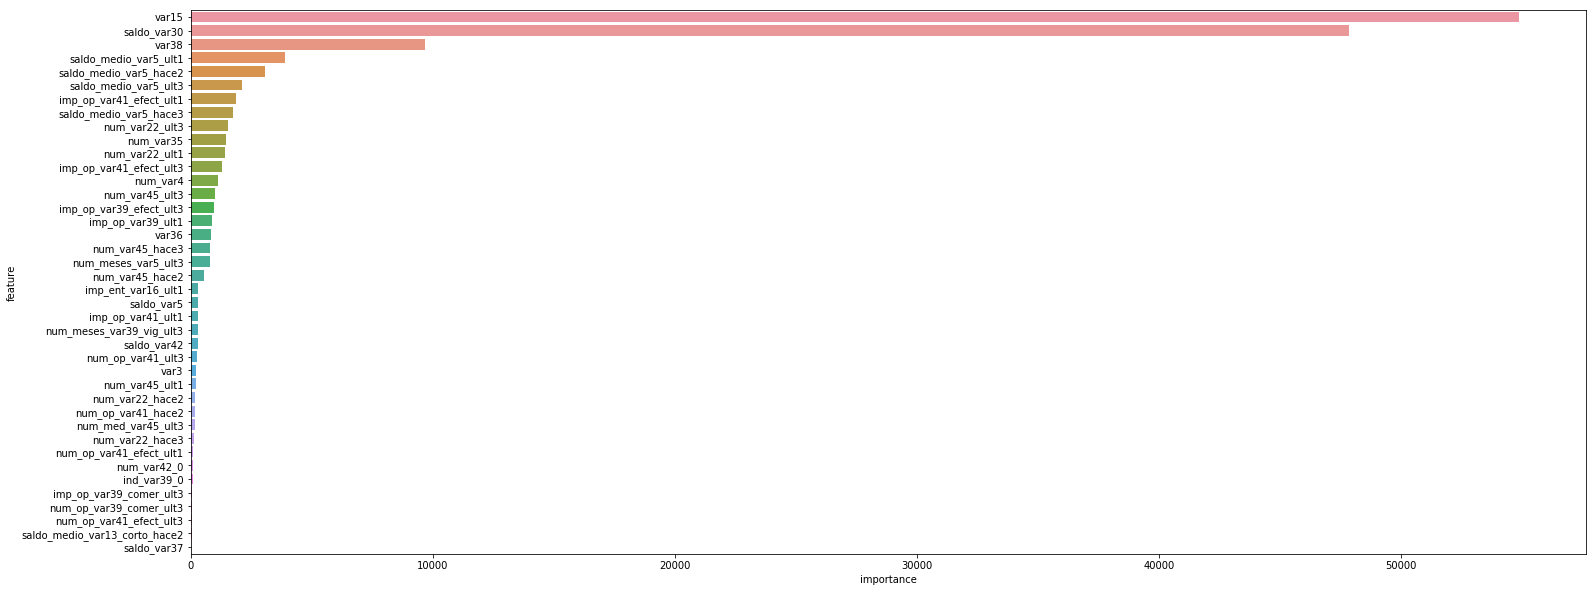

In [41]:
import seaborn as sns
def display_feature_importance(df):

    cols = df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = df.loc[df.feature.isin(cols)]
    plt.figure(figsize=(25, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.tight_layout

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = features
feature_importance_df["importance"] = clf.feature_importance(importance_type='gain')
display_feature_importance(feature_importance_df)

Text(0.5, 0, 'False Positive Rate')

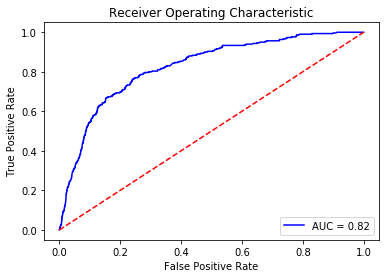

In [42]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [43]:
submission = pd.DataFrame({"ID":test_id, "TARGET": target})
submission.to_csv("submission.csv", index=False)

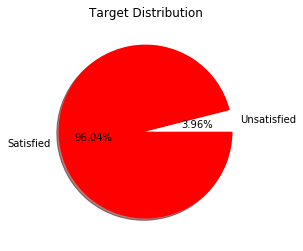

In [39]:
import matplotlib.pyplot as plt
    
dist_train = train.groupby("TARGET").size().reset_index(name='counts')
values = dist_train['counts']
colors = ['red', 'white']
labels = ['Satisfied', 'Unsatisfied']
plt.pie(values, colors=colors, labels=labels, autopct='%1.2f%%',
counterclock=False, shadow=True)
plt.title('Target Distribution')
plt.show()